# Boosting Models

1. Describe how the AdaBoost algorithm works.

*The main idea behind the AdaBoost lies behind the improvement of ensemble performance, where some particles may get more say than others. Moreover the order becomes important and the errors by the first model influences how the second one is made. The so-called `say amount` is dependent on how well it predicts the samples and is calculated by the following formula:* 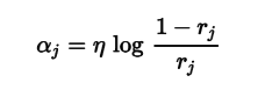

*Whereas `r(j)`, the error rate, is calculated using the next formula*: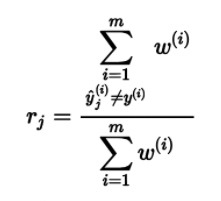

*`w(i)` stands for the i-th predictor weight. And the current amount of say influences the weights that are initially equal for and can be calculated as 1/m, where m is the amount of instances. But furher the sample weights are updated in the following manner:*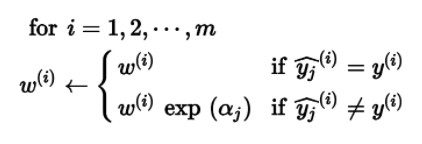  

*And then normalized by division by their total sum:* 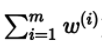

*For more clearness let's illustrate sample `weight` distribution using the graph:*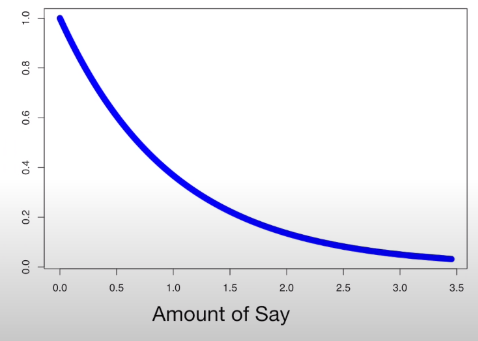

*Finally, a new predictor is trained using the updated weights, and the whole process is repeated. The algo stops when the desired number of predictors is reached or when a perfect predictor is found.
To make predictions, AdaBoost simply computes the predictions of all the predictors and weights them using the predictor weights a(j). The predicted case if the one that received the majority of `weighted votes`:* 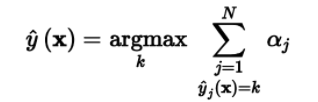

2. What is the principal difference between AdaBoost and Gradient Boosting algorithms?

*I'd like to illustrate the priciples and the differences on a particular mode: decision tree, nevertheless both boosting algoritms may be applied to a different models. (in sklearn no other estimators are allowed for the `Gradient Boosting`)*

*Well, `AdaBoost` initially builds a stump from the Training data. Then the amount of say that the stamp has on the final output is based on how well it is compensated for the previouse errors. Then the `AdaBoost` builds the new stump based on errors that the previouse one has made. And so on untill we get a perfect fit or out of forrest bounds. Contrastly the `Gradient Boosting` starts from making a single leaf instead of constructing a stamp or a tree this leaf represents an initial guess for the weight o all the samples. Only then the gradient boost builds a tree similarly this tree is built on the errors made by previous trees, unlikely this tree is usually larger than a stump. Also as `AdaBoost`, it does scale the trees, but not by the same amount. Then it builds the tree based on the previous tree's error and scales it. The process continues until the perfect fit is achieved or we are out of allowed trees again. To sum up it can be said that `Gradient Boosting` instead of tweaking the instance weights at every iteration like `AdaBoost` does, tries to fit the new predictor to the residual errors made by the previous*

3. If your Gradient Boosting ensemble overfits the training set, should
you increase or decrease the learning rate?

*As it is the too low bias is the cause of model overfitting, so to deal with it, the `learning reate` should be deccreased to coping with the residuals. Decreasing the `amount of predictors` may help as well*

4. Try to apply advanced boosting algorithms you have already known to a real dataset. Choose simple vanilla accuracy for classification or mean square error for regression as your control metric.

- Build end-to-end data preparation pipeline (sklearn.preprocessing + sklearn.pipeline + custom classes).
- For each algorithm:
    - Choose the best hyperparameters using cross-validation and tuning (sklearn.model_selection).
    - Select the most important features. Did you expect to see any of those?
- Compare algorithms. Are they different or not?
- Analyse results and interpret them.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
bank_df = pd.read_csv('german_credit_data.csv')
#drop first col
bank_df = bank_df.iloc[: , 1:]

bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [3]:
# custom classes:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    The class provides basic functionality for retrieving
    a subset of columns from the dataset.
    """
    
    def __init__(self, feature_names):
        """
        Initialize class instance by setting
        a list of columns to retrieve from the dataset.
        """
        super().__init__()
        #BaseEstimator.__init__(self)
        #TransformerMixin.__init__(self)
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        """
        Fit FeatureSelector to X, but really do nothing.
        Return self.
        """
        return self
    
    def transform(self, X, y=None):
        """
        Transform X using feature selection. 
        Return column-subset of X.
        """
        return X[self.feature_names]


class ColumnCatAgregator:
    """
    The class is used to store information about the conversion of a single column.
    """
    
    def __init__(self, column_name, param_dict):
        """
        Initialize ColumnTranslation instance.
        
        Parameters
        ----------
        column_name :  iterable, 
            the name of column to be agregated.
        param_dict: dict, 
            the dictionary, consistent of keys and values:
                key: list of str,
                    new categorical weight 
                value: weights to be replaced by certain key
        """
        self.param_dict = param_dict
        self.column_name = column_name


class CategoricalAgregator(BaseEstimator, TransformerMixin):
    """
    The class provides functionality for agregating ages into age groups.
    """
    
    def __init__(self, columns, drop=True):
        """
        Initialize class instance by setting convert options. 
        
        Parameters
        ----------
        columns : list of ColumnCatAgregator's, 
            object that provides column, bins and labels.
        drop: bool, 
            if True, remove the original columns from the dataset.
        """
        super().__init__()
        self.columns = columns
        self.drop = drop
    
    def fit(self, X, y=None):
        """
        Fit CategoricalAgregator to X, but really do nothing.
        Return self.
        """
        return self
    
    def transform(self, X, y=None):
        to_drop = []
        for col in self.columns:
            cat_name = f'{col.column_name}_Agg'
            to_drop.append(col.column_name)
            for key, value in col.param_dict.items():
                for weight in value:
                    # print(weight)
                    X[col.column_name].replace({weight : key}, inplace= True)
                    X[cat_name] = X[col.column_name]
                    # print(X[cat_name].value_counts())
        if self.drop:
            X.drop(to_drop, axis=1, inplace=True)
        return X

In [4]:
# perhaps Job is ordinal feature, I reckon as some sort of estimation it may be put in numeric pipeliine, but thrown after
# custom imputer built on correlation observations
# for the data observed does not contain outliners, StandardScaler fits well
numeric_pipeline = Pipeline(
    steps=[
        ('initial_num_selector', FeatureSelector(['Credit amount','Duration'])),
        ('num_scaler', StandardScaler())])

In [5]:
# here also the announced aggregations occur
# Just to play around I may have combined some of Purpose label values into bigger groups,
# but there are still no reason for doing them, cause there,
# despite the biggest cardinality among categorical features in the dataset still only 9 unique values

categorical_pipeline = Pipeline(
    steps=[
        ('categorical_selector', FeatureSelector(
            ['Sex','Housing','Saving accounts', 'Checking account', 'Purpose'])),
        ('categorical_agregator', CategoricalAgregator(
            [ColumnCatAgregator('Saving accounts', {'rich':['quite rich']})])),
        ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_pipiline_OHE', OneHotEncoder(sparse=False))])


In [6]:
# final pipeline construction
full_pipeline = FeatureUnion(transformer_list=[
    ('num', numeric_pipeline),
    ('cat', categorical_pipeline)])

# we will predict the prestige of the job by other credential values
y = bank_df['Job'].values
X = full_pipeline.fit_transform(bank_df)

In [7]:
# kfolds separation
kfold = KFold(n_splits=5, random_state=0, shuffle=True)

In [20]:
# parametres for gradient boosting
gb_params = {'learning_rate':(0.01, 0.05, 0.1, 0.25),
              'n_estimators':(10, 50, 100, 200),
              'subsample':(0.1, 0.25, 0.5, 1.0)}

In [21]:
grad_boost_est = GradientBoostingClassifier(random_state=0)
grc_est = GridSearchCV(grad_boost_est,
                       gb_params, scoring='accuracy',
                       cv=kfold, return_train_score = True)
grc_est.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': (0.01, 0.05, 0.1, 0.25),
                         'n_estimators': (10, 50, 100, 200),
                         'subsample': (0.1, 0.25, 0.5, 1.0)},
             return_train_score=True, scoring='accuracy')

In [22]:
params_table = (pd.concat([pd.DataFrame(grc_est.cv_results_["params"]),
           pd.DataFrame(grc_est.cv_results_["mean_test_score"],
                        columns=["Mean Accuracy"]),
           pd.DataFrame(grc_est.cv_results_["split4_test_score"],
                        columns=["Final Accuracy"])],axis=1)).set_index(['learning_rate','n_estimators', 'subsample'])

# the provided table illustrates dependance on hyperparams more clearly, however it's is rather big
# params_table

In [11]:
# best score for gradient
grc_est.best_params_

{'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.25}

In [18]:
grc_est.best_score_

0.644

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

KNN_classif = SGDClassifier()
tree_classif = DecisionTreeClassifier()
stump_classif = DecisionTreeClassifier(max_depth = 1)


ada_params = {'base_estimator':(KNN_classif, tree_classif, stump_classif),
              'learning_rate':(0.01, 0.05, 0.1, 0.25),
              'n_estimators':(10, 50, 100, 200)}

In [13]:
AdaBoost_est = AdaBoostClassifier(random_state=0, algorithm='SAMME')

Ada_est = GridSearchCV(AdaBoost_est,
                       ada_params, scoring='accuracy',
                       cv=kfold, return_train_score = True)

Ada_est.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__algorithm', 'estimator__base_estimator', 'estimator__learning_rate', 'estimator__n_estimators', 'estimator__random_state', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [14]:
Ada_est.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=AdaBoostClassifier(algorithm='SAMME', random_state=0),
             param_grid={'base_estimator': (SGDClassifier(),
                                            DecisionTreeClassifier(),
                                            DecisionTreeClassifier(max_depth=1)),
                         'learning_rate': (0.01, 0.05, 0.1, 0.25),
                         'n_estimators': (10, 50, 100, 200)},
             return_train_score=True, scoring='accuracy')

In [15]:
params_table = (pd.concat([pd.DataFrame(Ada_est.cv_results_["params"]),
           pd.DataFrame(Ada_est.cv_results_["mean_test_score"],
                        columns=["Mean Accuracy"]),
           pd.DataFrame(Ada_est.cv_results_["split4_test_score"],
                        columns=["Final Accuracy"])],axis=1)).set_index(['base_estimator','learning_rate', 'n_estimators'])

# the provided table illustrates dependance on hyperparams more clearly, however it's is rather big
#params_table

In [16]:
Ada_est.best_params_

{'base_estimator': SGDClassifier(), 'learning_rate': 0.01, 'n_estimators': 200}

In [17]:
Ada_est.best_score_

0.642

*5. What are the main disadvantages of boosting algorithms? How to work around them?

*There is a list of disadvantages I have discovered:*
1. Gradient Boosting Models will continue improving to minimize all errors. This can overemphasize outliers and cause overfitting
2. Computationally expensive - often require many trees (>1000) which can be time and memory exhaustive. If I'm not mistaken Google translate also used decision trees until 2016 but after they changed it in preference to more robust one because of its less complexity
3. The high flexibility results in many parameters that interact and influence heavily the behavior of the approach (number of iterations, tree depth, regularization parameters, etc.).
4. Less interpretative in nature. Business-related troubles.

*The possible solution:*
1. The way out may be found in manual hyperparameter regulation. For instance, we may reduce the learning rate, limit the number of trees for early stopping, or reset subsample(Stochastic Gradient Boosting) You may use `XGBoost` for it cares for automated early stopping also.
2. This may be fixed by reducing the number of trees in the model as well.
3. The impact of that may be particularly reduced with the GridSearch
4. In fact it is easily addressed with various 

*6. Does the Decision Tree algorithm are the single type of base estimator? Provide examples.

*Well, on the ideal level boosting models were designed to work with weak learners and there are no opsticals to apply them to all the models known. 
However, in sklearn Gradient Boosting supports only decision trees, while AdaBoost may work with some other estimators, even custom if they do support `sample_weight`, for example `SGD` or `decision trees` with various depth.*

*7. If your AdaBoost ensemble underfits the training data, which
hyperparameters should you tweak and how?

*If the situation described above occurs, I would definitely try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator, also I'll try to slightly increase the learning rate.*